In [89]:
# Data wrangling:
import pandas as pd

# Seleção e validação dos modelos:
from sklearn.model_selection import train_test_split

# Modelos:
from pmdarima.arima import auto_arima

# Deployment:
import pickle

In [90]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
rcParams['figure.figsize'] = 15, 6

## DataFrame:

In [91]:
path = r'../../data/dataset_CASTING_DB106.csv'
df = pd.read_csv(
    filepath_or_buffer=path,
    parse_dates=['VUF_DT'],
    index_col='VUF_DT',
    usecols=['VUF_DT', 'VUF_VLRLIQFINAL']
)

In [92]:
df.head()

,VUF_VLRLIQFINAL
VUF_DT,
2023-05-10,152.0
2023-05-15,55.0
2023-06-22,45900.0
2023-05-05,51.0
2023-05-05,105.0


## Preparação dos dados:

### Agrupando por mês:

In [93]:
df = (
    df.groupby(
        (df.index).to_period("M")
    )['VUF_VLRLIQFINAL'].sum()
)

### Removendo o mês de outubro:

In [94]:
df = df.drop(df.index[-1])

## Visualização:

### ACF:

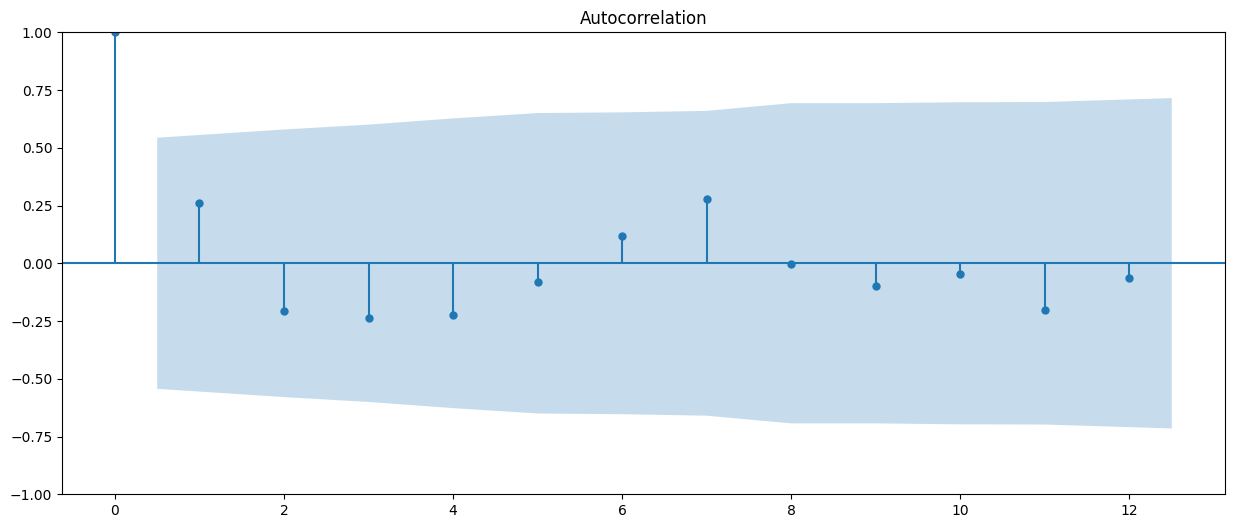

In [95]:
plot_acf(df)
plt.show()

### PACF:

In [96]:
# plot_pacf(df)
# plt.show()

## Modelo:

### Procurando Modelo:

In [97]:
model = auto_arima(
    df,
)

### Melhor Resultado:

In [98]:
print(model.aic())

345.8056769598071


In [99]:
print(model.aicc())

347.0056769598071


In [100]:
print(model.bic())

346.93557567473016


***Obs:*** *Quanto menor o valor melhor.*

### Train-test Split:

In [101]:
df.index

PeriodIndex(['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
             '2022-10', '2022-11', '2022-12', '2023-01', '2023-05', '2023-06',
             '2023-09'],
            dtype='period[M]', name='VUF_DT')

In [102]:
train = df.loc['2022-04-01':'2023-06-01']
test = df.loc['2023-09-01':]

### Treinando o modelo:

In [103]:
model.fit(train)

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

## Avaliação:

### Resíduo:

In [104]:
test - model.predict(n_periods=1)

2023-04   NaN
2023-09   NaN
Freq: M, dtype: float64

***Resíduo*** = *Valor Real - Valor Previsto*

### Deployment:

In [105]:
# path = r'../../models/DB106_arima.pkl' 

# with open(path, 'wb') as file:
#     pickle.dump(model, file)